# Self-Organizing Maps (SOMs) Notebook
## Data extraction step - Step 1

**Notebook by Maria J. Molina (NCAR) and Alice DuVivier (NCAR).**

This Notebook reads in data from the CESM2-LE for a user-specified variable. It subsets the data by a user-specified coastal region around Antarctica.

Before starting, make sure you went to https://github.com/NCAR/ncar-python-tutorial#step-2-install-miniconda-and-create-environments
and completed steps 1 through 3.

Also, make sure you activate your conda environment containing the packages needed for this work ``antarctica_som_env`` within the drop down menu located in the top right of this notebook.

In [1]:
# Needed imports

from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product

import intake
from distributed import Client
from ncar_jobqueue import NCARCluster
import dask

In [2]:
# start up dask

cluster = NCARCluster(memory='100 GB')
cluster.scale(40) # number of workers requested
#cluster.adapt(1,80) # min and max
client = Client(cluster)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39489 instead
  f"Port {expected} is already in use.\n"


import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='32 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    #resource_spec='select=1:ncpus=2:mem=256GB', # Specify resources
    project='P93300665', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(32)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/39489/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/39489/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:39884,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/39489/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Set user-specified information

In [4]:
# set region of interest
# needed for plotting and choosing a mask
titles     = ['Ross Sea', 'Amundsen Bellingshausen Sea', 'Weddell Sea', 'Pacific Ocean', 'Indian Ocean']
shorts     = ['Ross', 'AMB', 'Wed', 'Pac', 'Ind']
masks      = ['Ross_mask', 'BAm_mask', 'Wed_mask', 'Pac_mask', 'Ind_mask']
lat_maxes  = [-72, -65, -65, -60, -60] 
lat_mins   = [-85, -85, -85, -80, -80]
lon_maxes  = [200, 300, 300, 90, 160] 
lon_mins   = [160, 220, 20, 20, 90]
lon_avgs   = [190, 260, 340, 55, 125]

In [5]:
# set s, which is the paired values above 
s = 0
sector_title = titles[s]
sector_short = shorts[s]
mask_in = masks[s]
lat_max = lat_maxes[s]
lat_min = lat_mins[s]
lon_max = lon_maxes[s]
lon_min = lon_mins[s]
lon_avg = lon_avgs[s]

## Section 1: Load and get correct training data

### Load in the data

In [6]:
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

cat = intake.open_esm_datastore(catalog_file)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [7]:
# set some info for the CESM2-LE data
# set: variable to test, the location of the data, which ensemble member
var_in = 'aice_d'
 # do not want smbb data
forcing = 'cmip6'

In [8]:
subset = cat.search(variable=var_in, forcing_variant=forcing)

In [9]:
#subset
subset.df.head()

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,ice,cice.h1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,aice_d,1850-01-01,1860-01-01,18500101-18600101,ice area (aggregate),1,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
1,ice,cice.h1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,aice_d,1860-01-02,1870-01-01,18600102-18700101,ice area (aggregate),1,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
2,ice,cice.h1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,aice_d,1870-01-02,1880-01-01,18700102-18800101,ice area (aggregate),1,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
3,ice,cice.h1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,aice_d,1880-01-02,1890-01-01,18800102-18900101,ice area (aggregate),1,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
4,ice,cice.h1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,aice_d,1890-01-02,1900-01-01,18900102-19000101,ice area (aggregate),1,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1


In [10]:
# make arrays of half (25) of the CESM2-LE members 
# select every other from the large ensemble of both macro and micro starts
# note that the naming of the files (YYYY.#### e.g. 1001.001) doesn't match the member_id directly, 
# but the ensemble number (### e.g. 001) does match the member_id field r? directly. So use this to search

# set list of members from the dataset
member_ids = subset.df.member_id.unique()

# set list of members to KEEP
keep_list = ['r1i', 'r3i', 'r5i','r7i', 'r9i']


In [11]:
member_keep = [] # make a list to fill

for member in keep_list:
    for member_id in member_ids:
        if member in member_id:
            member_keep.append(member_id)

In [12]:
#check that we're keeping the right ones
member_keep

['r1i1001p1f1',
 'r1i1231p1f1',
 'r1i1251p1f1',
 'r1i1281p1f1',
 'r1i1301p1f1',
 'r3i1041p1f1',
 'r3i1231p1f1',
 'r3i1251p1f1',
 'r3i1281p1f1',
 'r3i1301p1f1',
 'r5i1081p1f1',
 'r5i1231p1f1',
 'r5i1251p1f1',
 'r5i1281p1f1',
 'r5i1301p1f1',
 'r7i1121p1f1',
 'r7i1231p1f1',
 'r7i1251p1f1',
 'r7i1281p1f1',
 'r7i1301p1f1',
 'r9i1161p1f1',
 'r9i1231p1f1',
 'r9i1251p1f1',
 'r9i1281p1f1',
 'r9i1301p1f1']

In [13]:
# now reduce subset based on just the members to keep
subset = subset.search(member_id=member_keep)

In [14]:
%%time
#actually load the data we selected into a dataset
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets = subset.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})

#dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 19.7 s, sys: 1.42 s, total: 21.1 s
Wall time: 28.1 s


In [15]:
# print names of the dataset keys, which refer to each of the ensembles loaded
dsets.keys()

dict_keys(['ice.ssp370.cice.h1.cmip6.aice_d', 'ice.historical.cice.h1.cmip6.aice_d'])

In [18]:
# Look at just one dataset key to see what it looks like. 
# Note that for 1001 there is one member_id, but for 1231 there are 5 member_ids
# these refer to the individual ensemble members!

dsets['ice.historical.cice.h1.cmip6.aice_d']
#dsets['ice.historical.cice.h1.cmip6.1231.aice_d']

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, time: 60225, d2: 2, member_id: 25)
Coordinates:
    TLON         (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT         (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULON         (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT         (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time         (time) object 1850-01-02 00:00:00 ... 2015-01-01 00:00:00
  * member_id    (member_id) <U11 'r1i1001p1f1' 'r1i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nj, ni, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (nc) float32 dask.array<chunksize=(5,), meta=np.ndarray>
    VGRDi        (nkice) float32 dask.array<chunksize=(8,), meta=np.ndarray>
    VGRDs        (nksnow) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    VGRDb        (nkbio) float32 dask.array<chunksize=(5,), meta=np.ndarray>
    tmask        (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    tarea        (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    latt_bounds  (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lonu_bounds  (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    latu_bounds  (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    time_bounds  (time, d2) object dask.array<chunksize=(240, 2), meta=np.ndarray>
    aice_d       (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 240, 384, 320), meta=np.ndarray>
Attributes: (12/13)
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    contents:                Diagnostic and Prognostic Variables
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:        day_1
    conventions:             CF-1.0
    comment:                 All years have exactly 365 days
    ...                      ...
    comment3:                seconds elapsed into model date:      0
    title:                   b.e21.BHISTcmip6.f09_g17.LE2-1301.009
    history:                 This dataset was created on 2020-01-31 at 16:26\...
    intake_esm_varname:      ['aice_d']
    io_flavor:               io_pio
    intake_esm_dataset_key:  ice.historical.cice.h1.cmip6.aice_d

In [19]:
# load in the historical and future datasets

historicals = []
futures = []

for key in sorted(dsets.keys()):
    if 'historical' in key:
        historicals.append(dsets[key])
        print(key)
    elif 'ssp370' in key:
        futures.append(dsets[key])
        print(key)

ice.historical.cice.h1.cmip6.aice_d
ice.ssp370.cice.h1.cmip6.aice_d


In [20]:
# Now put these into an array by member_id
historical_ds = xr.concat(historicals, dim='member_id')
future_ds = xr.concat(futures, dim='member_id')

In [21]:
# note that the historical and future xarray datasets have the same coordinates and dimensions *except* time, 
# so we need to concatenate over time
ds_ice = xr.concat([historical_ds,future_ds],dim='time')

In [22]:
ds_ice

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, time: 91615, member_id: 25, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT         (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    ULON         (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT         (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan
  * time         (time) object 1850-01-02 00:00:00 ... 2101-01-01 00:00:00
  * member_id    (member_id) <U11 'r1i1001p1f1' 'r1i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nj, ni, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (time, member_id, nc) float32 dask.array<chunksize=(60225, 25, 5), meta=np.ndarray>
    VGRDi        (time, member_id, nkice) float32 dask.array<chunksize=(60225, 25, 8), meta=np.ndarray>
    VGRDs        (time, member_id, nksnow) float32 dask.array<chunksize=(60225, 25, 3), meta=np.ndarray>
    VGRDb        (time, member_id, nkbio) float32 dask.array<chunksize=(60225, 25, 5), meta=np.ndarray>
    tmask        (time, member_id, nj, ni) float32 dask.array<chunksize=(60225, 25, 384, 320), meta=np.ndarray>
    tarea        (time, member_id, nj, ni) float32 dask.array<chunksize=(60225, 25, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(60225, 25, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(60225, 25, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(60225, 25, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(60225, 25, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(25, 240, 2), meta=np.ndarray>
    aice_d       (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 240, 384, 320), meta=np.ndarray>
Attributes: (12/13)
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    contents:                Diagnostic and Prognostic Variables
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:        day_1
    conventions:             CF-1.0
    comment:                 All years have exactly 365 days
    ...                      ...
    comment3:                seconds elapsed into model date:      0
    title:                   b.e21.BHISTcmip6.f09_g17.LE2-1301.009
    history:                 This dataset was created on 2020-01-31 at 16:26\...
    intake_esm_varname:      ['aice_d']
    io_flavor:               io_pio
    intake_esm_dataset_key:  ice.historical.cice.h1.cmip6.aice_d

In [23]:
# we need to shift time by 1 day because of weird CESM conventions
ds_ice = ds_ice.assign_coords(time=ds_ice.coords["time"]-timedelta(days=1))

## Section 2: Drop the lat/lons that we don't need

In [24]:
# Load in the masking file
ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/masks/antarctic_ocean_masks_2.nc')

# need to use the intersection of masks for a particular sector (e.g. Ross_mask) with the coastal mask (coast_mask)
# create array for mask
ds_mask = xr.where((ds_masks[mask_in]==1)&(ds_masks['coast_mask']==1),ds_masks['coast_mask'],0)

# rename the coordinates for the mask
ds_mask=ds_mask.rename({'nlat':'nj','nlon': 'ni'})

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sh_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'socn_mask' has multiple fill values {0, -2147483647}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Wed_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Ross_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  de

In [25]:
# stack the mask for correct value dropping
mask_stacked = ds_mask.stack(horizontal=("nj","ni"))

In [26]:
mask_stacked

<xarray.DataArray (horizontal: 122880)>
dask.array<reshape, shape=(122880,), dtype=float32, chunksize=(122880,), chunktype=numpy.ndarray>
Coordinates:
  * horizontal  (horizontal) MultiIndex
  - nj          (horizontal) int64 0 0 0 0 0 0 0 ... 383 383 383 383 383 383 383
  - ni          (horizontal) int64 0 1 2 3 4 5 6 ... 313 314 315 316 317 318 319

In [27]:
ds_ice_stacked = ds_ice[var_in].stack(horizontal=("nj","ni"))

In [28]:
ds_ice_stacked

,Array,Chunk
Bytes,1.02 TiB,112.50 MiB
Shape,"(25, 91615, 122880)","(1, 240, 122880)"
Count,60950 Tasks,10050 Chunks
Type,float32,numpy.ndarray


In [29]:
# now drop points that are masked
ds_ice_masked = ds_ice_stacked.where(mask_stacked,drop=True)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [30]:
%%time
# actually load the data so it doesn't get too big later and makes DASK angry
ds_ice_masked.load()

CPU times: user 41.7 s, sys: 10.8 s, total: 52.6 s
Wall time: 2min 12s


<xarray.DataArray 'aice_d' (member_id: 25, time: 91615, horizontal: 349)>
array([[[3.3251271e-01, 1.7190203e-02, 6.6164922e-04, ...,
         7.7838933e-01, 7.6998144e-01, 7.6464283e-01],
        [3.2381192e-01, 1.3520100e-02, 4.8118303e-04, ...,
         7.8039563e-01, 7.7828974e-01, 7.7299577e-01],
        [3.1019351e-01, 1.0956603e-02, 3.6637706e-04, ...,
         7.7610195e-01, 7.7727228e-01, 7.7100104e-01],
        ...,
        [1.0779322e-03, 2.2707187e-04, 2.1995771e-04, ...,
         6.1746353e-01, 5.8762872e-01, 5.8396178e-01],
        [9.6935179e-04, 2.0338038e-04, 1.9643902e-04, ...,
         5.7938474e-01, 5.5945957e-01, 5.4953772e-01],
        [8.6726708e-04, 1.8104438e-04, 1.7425661e-04, ...,
         5.4652566e-01, 5.2449435e-01, 5.1160324e-01]],

       [[2.2750277e-02, 3.8074187e-03, 2.1610742e-03, ...,
         9.1446048e-01, 9.1303623e-01, 9.0475297e-01],
        [2.0740721e-02, 3.4204188e-03, 2.4557621e-03, ...,
         9.1565418e-01, 9.1402805e-01, 9.0403092e-01],
        [1.9832499e-02, 3.2363716e-03, 2.2433635e-03, ...,
         9.2413908e-01, 9.2164093e-01, 9.1287744e-01],
...
        [2.2135647e-02, 2.5895217e-03, 1.1567186e-03, ...,
         3.6506671e-01, 4.4211411e-01, 4.2554298e-01],
        [2.0244749e-02, 2.1816646e-03, 1.0134066e-03, ...,
         3.3645800e-01, 4.0957817e-01, 3.9347842e-01],
        [1.8311217e-02, 1.9235692e-03, 8.9707156e-04, ...,
         2.8799164e-01, 3.4711608e-01, 3.3274233e-01]],

       [[2.0953495e-02, 3.6481975e-03, 1.3255312e-03, ...,
         8.4568745e-01, 8.1399691e-01, 8.2081437e-01],
        [1.7465912e-02, 3.2662812e-03, 1.2904500e-03, ...,
         8.4210241e-01, 8.1114286e-01, 8.1725615e-01],
        [1.4694057e-02, 2.5111942e-03, 1.0569353e-03, ...,
         8.3819371e-01, 8.1381023e-01, 8.1523430e-01],
        ...,
        [8.9219803e-01, 9.0270025e-01, 8.6926758e-01, ...,
         5.5897963e-01, 6.3260525e-01, 5.9605575e-01],
        [8.4246671e-01, 8.5955381e-01, 8.2978886e-01, ...,
         5.0789028e-01, 5.9452581e-01, 5.5420357e-01],
        [8.3993775e-01, 8.7490457e-01, 8.6229330e-01, ...,
         4.6361050e-01, 5.5880135e-01, 5.1560241e-01]]], dtype=float32)
Coordinates:
    TLON        (horizontal) float32 194.6 195.7 196.8 ... 163.1 160.8 161.9
    TLAT        (horizontal) float32 -78.15 -78.15 -78.15 ... -67.47 -67.47
    ULON        (horizontal) float32 195.1 196.2 197.4 ... 163.6 161.4 162.5
    ULAT        (horizontal) float32 -77.88 -77.88 -77.88 ... -67.73 -67.2 -67.2
  * time        (time) object 1850-01-01 00:00:00 ... 2100-12-31 00:00:00
  * member_id   (member_id) <U11 'r1i1001p1f1' 'r1i1231p1f1' ... 'r9i1301p1f1'
  * horizontal  (horizontal) MultiIndex
  - nj          (horizontal) int64 2 2 2 2 3 3 3 3 3 ... 20 20 20 21 21 21 22 22
  - ni          (horizontal) int64 208 209 210 211 194 ... 178 179 180 178 179
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [31]:
# Now also subset by some lat/lon values to better narrow down the region
if sector_short == 'Wed':
    ds_ice_masked_subset = ds_ice_masked.where(
                             ((ds_ice_masked['TLAT']<lat_max) & (ds_ice_masked['TLAT']>lat_min)) &\
                             ((ds_ice_masked['TLON']<lon_min) | (ds_ice_masked['TLON']>lon_max)),
                             drop=True)  
else:
    
    ds_ice_masked_subset = ds_ice_masked.where(
                             (ds_ice_masked['TLAT']<lat_max) & (ds_ice_masked['TLAT']>lat_min) & \
                             (ds_ice_masked['TLON']>lon_min) & (ds_ice_masked['TLON']<lon_max), 
                             drop=True) 

In [32]:
ds_ice_masked_subset

<xarray.DataArray 'aice_d' (member_id: 25, time: 91615, horizontal: 189)>
array([[[3.32512707e-01, 1.71902031e-02, 6.61649217e-04, ...,
         2.45890811e-01, 1.64621919e-02, 7.23768433e-04],
        [3.23811918e-01, 1.35201002e-02, 4.81183029e-04, ...,
         1.47129655e-01, 7.68580474e-03, 4.50647698e-04],
        [3.10193509e-01, 1.09566031e-02, 3.66377062e-04, ...,
         1.08930945e-01, 5.07903658e-03, 3.31470306e-04],
        ...,
        [1.07793219e-03, 2.27071869e-04, 2.19957714e-04, ...,
         3.62208873e-01, 8.38366672e-02, 1.99297983e-02],
        [9.69351793e-04, 2.03380376e-04, 1.96439025e-04, ...,
         2.75187761e-01, 6.04928173e-02, 1.68439578e-02],
        [8.67267081e-04, 1.81044379e-04, 1.74256609e-04, ...,
         2.07616448e-01, 5.04346229e-02, 1.47602484e-02]],

       [[2.27502771e-02, 3.80741875e-03, 2.16107420e-03, ...,
         2.79807597e-01, 1.18857669e-02, 3.13366880e-04],
        [2.07407214e-02, 3.42041883e-03, 2.45576212e-03, ...,
         2.15252131e-01, 7.40053412e-03, 2.47772376e-04],
        [1.98324993e-02, 3.23637156e-03, 2.24336353e-03, ...,
         1.63404524e-01, 4.86340420e-03, 2.00986949e-04],
...
        [2.21356470e-02, 2.58952170e-03, 1.15671859e-03, ...,
         1.03241391e-01, 1.15889283e-02, 8.77201383e-04],
        [2.02447493e-02, 2.18166457e-03, 1.01340655e-03, ...,
         9.21294242e-02, 1.11371009e-02, 7.88106641e-04],
        [1.83112174e-02, 1.92356925e-03, 8.97071557e-04, ...,
         7.79191554e-02, 1.06310053e-02, 7.52393680e-04]],

       [[2.09534951e-02, 3.64819751e-03, 1.32553116e-03, ...,
         8.46083462e-01, 8.44449341e-01, 7.80774951e-01],
        [1.74659118e-02, 3.26628122e-03, 1.29044999e-03, ...,
         8.40407372e-01, 8.43683660e-01, 7.64468789e-01],
        [1.46940574e-02, 2.51119421e-03, 1.05693529e-03, ...,
         8.36498260e-01, 8.46006036e-01, 7.59186268e-01],
        ...,
        [8.92198026e-01, 9.02700245e-01, 8.69267583e-01, ...,
         1.99279681e-01, 1.36185316e-02, 4.56594722e-03],
        [8.42466712e-01, 8.59553814e-01, 8.29788864e-01, ...,
         2.32511848e-01, 1.77449752e-02, 4.56470344e-03],
        [8.39937747e-01, 8.74904573e-01, 8.62293303e-01, ...,
         1.38748080e-01, 9.31561925e-03, 4.14649583e-03]]], dtype=float32)
Coordinates:
    TLON        (horizontal) float32 194.6 195.7 196.8 ... 172.1 173.2 174.3
    TLAT        (horizontal) float32 -78.15 -78.15 -78.15 ... -72.28 -72.28
    ULON        (horizontal) float32 195.1 196.2 197.4 ... 172.6 173.8 174.9
    ULAT        (horizontal) float32 -77.88 -77.88 -77.88 ... -72.01 -72.01
  * time        (time) object 1850-01-01 00:00:00 ... 2100-12-31 00:00:00
  * member_id   (member_id) <U11 'r1i1001p1f1' 'r1i1231p1f1' ... 'r9i1301p1f1'
  * horizontal  (horizontal) MultiIndex
  - nj          (horizontal) int64 2 2 2 2 3 3 3 3 3 ... 12 12 12 12 13 13 13 13
  - ni          (horizontal) int64 208 209 210 211 194 ... 190 187 188 189 190
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

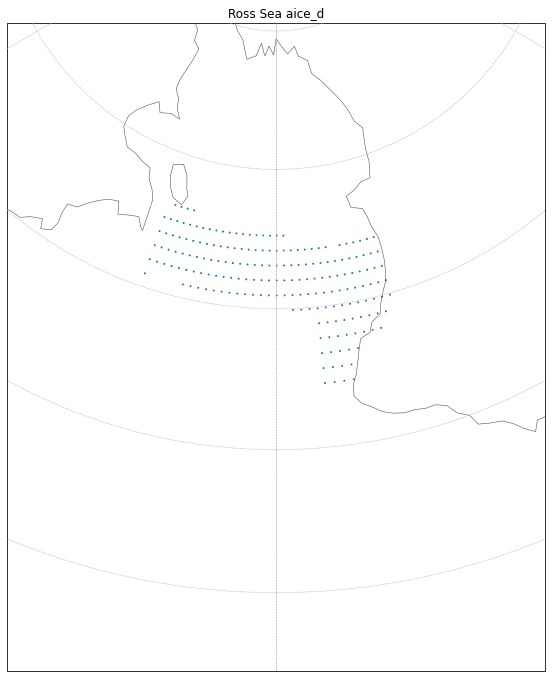

In [33]:
# Want to check that we're plotting the correct area for the training data
# using pcolor here

# Choose just one timestep
data = ds_ice_masked_subset.sel(member_id='r1i1281p1f1').isel(time=1000)

fig = plt.figure(figsize=(12,9))

ax = plt.axes([0.,0.,1.,1.], projection=ccrs.SouthPolarStereo(central_longitude=0))

ax.set_title(sector_title +' '+var_in, fontsize=12)

# add cyclic point -- doesnt work due to nans
#data_, lons_ = add_cyclic_point(data, coord=np.array(lon_new))

# doing scatter instead for now
cs1 = ax.scatter(     data.coords['TLON'].values,    
                     data.coords['TLAT'].values, 
                     data, cmap='Blues',
                vmin=0,vmax=5,
                #vmin=-10,vmax=0,
                     transform=ccrs.PlateCarree())

ax.set_extent([lon_min,lon_max,lat_min,lat_max+10], ccrs.PlateCarree())

############################################
# Cartopy coastline and the land feature dont match perfectly for antarctica!
# maybe just use one of them? i dont know which one is more accurate for your data 

ax.coastlines(resolution='110m', color='0.25', linewidth=0.5, zorder=10)  

#ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')

############################################

ax.gridlines(linestyle='--', linewidth=0.5, zorder=11)

#plt.colorbar(cs1)

#plt.savefig(sector_short+'_'+var_in+'_1.png', bbox_inches='tight', dpi=200)

plt.show()

## Section 3: Subset the times we want to train on

In [34]:
ds_ice_masked_subset.time

<xarray.DataArray 'time' (time: 91615)>
array([cftime.DatetimeNoLeap(1850, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 12, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2100-12-31 00:00:00

In [35]:
# keep just years greater than 1980 and less than 2080 
yy_st = "1980"
yy_ed = "2080"
ds_ice_masked_subset = ds_ice_masked_subset.sel(time=slice(yy_st, yy_ed))

In [36]:
ds_ice_masked_subset.time.dt.month

<xarray.DataArray 'month' (time: 36865)>
array([ 1,  1,  1, ..., 12, 12, 12])
Coordinates:
  * time     (time) object 1980-01-01 00:00:00 ... 2080-12-31 00:00:00

In [40]:
# keep just times corresponding to winter (SH: jul, aug, sept)
ds_ice_winter = ds_ice_masked_subset.isel(time=ds_ice_masked_subset.time.dt.month.isin([7,8,9]))

In [41]:
ds_ice_winter.time

<xarray.DataArray 'time' (time: 9292)>
array([cftime.DatetimeNoLeap(1980, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1980, 7, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1980, 7, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2080, 9, 28, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2080, 9, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2080, 9, 30, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1980-07-01 00:00:00 ... 2080-09-30 00:00:00

In [42]:
%%time
# actually load the data so it doesn't get too big later and makes DASK angry
ds_ice_winter.load()

CPU times: user 488 µs, sys: 0 ns, total: 488 µs
Wall time: 521 µs


<xarray.DataArray 'aice_d' (member_id: 25, time: 9292, horizontal: 189)>
array([[[0.9983598 , 0.9995389 , 0.99909925, ..., 0.9468296 ,
         0.9421642 , 0.94245183],
        [0.99541724, 0.9919233 , 0.9882547 , ..., 0.93655634,
         0.93556905, 0.9367629 ],
        [0.9773403 , 0.97727036, 0.9700464 , ..., 0.92814344,
         0.9324318 , 0.93463767],
        ...,
        [0.96583545, 0.9857848 , 0.99739116, ..., 0.92926526,
         0.9222305 , 0.9407688 ],
        [0.9656008 , 0.98381245, 0.99446183, ..., 0.93200344,
         0.92661136, 0.94209164],
        [0.9538357 , 0.9483064 , 0.94912326, ..., 0.93081677,
         0.9330013 , 0.9426145 ]],

       [[0.9348313 , 0.93056875, 0.9411928 , ..., 0.9241948 ,
         0.91733104, 0.9139551 ],
        [0.9177643 , 0.88969517, 0.90797555, ..., 0.9446003 ,
         0.9231118 , 0.9231772 ],
        [0.9462742 , 0.91276777, 0.9031117 , ..., 0.95110196,
         0.9355946 , 0.9338021 ],
...
        [0.99825364, 0.9972826 , 0.9909734 , ..., 0.9270326 ,
         0.9400319 , 0.9599537 ],
        [0.9995149 , 0.9982396 , 0.9911294 , ..., 0.9139058 ,
         0.9402269 , 0.9644252 ],
        [0.9998217 , 0.99990875, 0.9999298 , ..., 0.91640365,
         0.9485087 , 0.9614749 ]],

       [[0.9979567 , 0.98870736, 0.9819712 , ..., 0.925129  ,
         0.9367023 , 0.94777256],
        [0.99885243, 0.99207586, 0.9812832 , ..., 0.92318964,
         0.94123316, 0.95840496],
        [0.9996656 , 0.99959403, 0.9996913 , ..., 0.92022353,
         0.94041556, 0.9606299 ],
        ...,
        [0.9387336 , 0.9231891 , 0.9398404 , ..., 0.9222947 ,
         0.9173544 , 0.9253043 ],
        [0.9611096 , 0.95707136, 0.9694547 , ..., 0.9226793 ,
         0.9214164 , 0.9280648 ],
        [0.9545366 , 0.9278879 , 0.9263938 , ..., 0.9245984 ,
         0.9269423 , 0.93356514]]], dtype=float32)
Coordinates:
    TLON        (horizontal) float32 194.6 195.7 196.8 ... 172.1 173.2 174.3
    TLAT        (horizontal) float32 -78.15 -78.15 -78.15 ... -72.28 -72.28
    ULON        (horizontal) float32 195.1 196.2 197.4 ... 172.6 173.8 174.9
    ULAT        (horizontal) float32 -77.88 -77.88 -77.88 ... -72.01 -72.01
  * time        (time) object 1980-07-01 00:00:00 ... 2080-09-30 00:00:00
  * member_id   (member_id) <U11 'r1i1001p1f1' 'r1i1231p1f1' ... 'r9i1301p1f1'
  * horizontal  (horizontal) MultiIndex
  - nj          (horizontal) int64 2 2 2 2 3 3 3 3 3 ... 12 12 12 12 13 13 13 13
  - ni          (horizontal) int64 208 209 210 211 194 ... 190 187 188 189 190
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

## Section 4: Get data into format needed by miniSOM

In [43]:
ds_ice_winter.shape

(25, 9292, 189)

In [44]:
# Flatten the times and member_id
training_subset = ds_ice_winter.stack(new=("member_id","time"))

In [45]:
training_subset = training_subset.transpose()

In [46]:
training_subset

<xarray.DataArray 'aice_d' (new: 232300, horizontal: 189)>
array([[0.9983598 , 0.9995389 , 0.99909925, ..., 0.9468296 , 0.9421642 ,
        0.94245183],
       [0.99541724, 0.9919233 , 0.9882547 , ..., 0.93655634, 0.93556905,
        0.9367629 ],
       [0.9773403 , 0.97727036, 0.9700464 , ..., 0.92814344, 0.9324318 ,
        0.93463767],
       ...,
       [0.9387336 , 0.9231891 , 0.9398404 , ..., 0.9222947 , 0.9173544 ,
        0.9253043 ],
       [0.9611096 , 0.95707136, 0.9694547 , ..., 0.9226793 , 0.9214164 ,
        0.9280648 ],
       [0.9545366 , 0.9278879 , 0.9263938 , ..., 0.9245984 , 0.9269423 ,
        0.93356514]], dtype=float32)
Coordinates:
    TLON        (horizontal) float32 194.6 195.7 196.8 ... 172.1 173.2 174.3
    TLAT        (horizontal) float32 -78.15 -78.15 -78.15 ... -72.28 -72.28
    ULON        (horizontal) float32 195.1 196.2 197.4 ... 172.6 173.8 174.9
    ULAT        (horizontal) float32 -77.88 -77.88 -77.88 ... -72.01 -72.01
  * horizontal  (horizontal) MultiIndex
  - nj          (horizontal) int64 2 2 2 2 3 3 3 3 3 ... 12 12 12 12 13 13 13 13
  - ni          (horizontal) int64 208 209 210 211 194 ... 190 187 188 189 190
  * new         (new) MultiIndex
  - member_id   (new) object 'r1i1001p1f1' 'r1i1001p1f1' ... 'r9i1301p1f1'
  - time        (new) object 1980-07-01 00:00:00 ... 2080-09-30 00:00:00
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [47]:
# assign to numpy array object
subsetarray = training_subset.values

In [48]:
# triple check the data dims/shape
print(subsetarray.shape)
# confirm there are no NaN values in array for training (should print False if no values)
print(np.isnan(subsetarray).any())

(232300, 189)
False


In [49]:
training_subset

<xarray.DataArray 'aice_d' (new: 232300, horizontal: 189)>
array([[0.9983598 , 0.9995389 , 0.99909925, ..., 0.9468296 , 0.9421642 ,
        0.94245183],
       [0.99541724, 0.9919233 , 0.9882547 , ..., 0.93655634, 0.93556905,
        0.9367629 ],
       [0.9773403 , 0.97727036, 0.9700464 , ..., 0.92814344, 0.9324318 ,
        0.93463767],
       ...,
       [0.9387336 , 0.9231891 , 0.9398404 , ..., 0.9222947 , 0.9173544 ,
        0.9253043 ],
       [0.9611096 , 0.95707136, 0.9694547 , ..., 0.9226793 , 0.9214164 ,
        0.9280648 ],
       [0.9545366 , 0.9278879 , 0.9263938 , ..., 0.9245984 , 0.9269423 ,
        0.93356514]], dtype=float32)
Coordinates:
    TLON        (horizontal) float32 194.6 195.7 196.8 ... 172.1 173.2 174.3
    TLAT        (horizontal) float32 -78.15 -78.15 -78.15 ... -72.28 -72.28
    ULON        (horizontal) float32 195.1 196.2 197.4 ... 172.6 173.8 174.9
    ULAT        (horizontal) float32 -77.88 -77.88 -77.88 ... -72.01 -72.01
  * horizontal  (horizontal) MultiIndex
  - nj          (horizontal) int64 2 2 2 2 3 3 3 3 3 ... 12 12 12 12 13 13 13 13
  - ni          (horizontal) int64 208 209 210 211 194 ... 190 187 188 189 190
  * new         (new) MultiIndex
  - member_id   (new) object 'r1i1001p1f1' 'r1i1001p1f1' ... 'r9i1301p1f1'
  - time        (new) object 1980-07-01 00:00:00 ... 2080-09-30 00:00:00
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

## Section 5: Save data as a netcdf

In [50]:
fout = 'training_data_region_'+sector_short+'_'+var_in

In [51]:
ds_to_save = xr.Dataset({'train_data': (['training_times','points'], subsetarray)}, 
                        coords={'time':(['training_times'],training_subset.time.values),
                                'member_id':(['training_times'],training_subset.member_id.values),
                                'TLON':(['points'],training_subset.TLON.values),
                                'TLAT':(['points'],training_subset.TLAT.values),
                                'nj':(['points'],training_subset.nj.values),
                                'ni':(['points'],training_subset.ni.values)},
                        attrs={'Author': 'Alice DuVivier'})

In [52]:
ds_to_save

<xarray.Dataset>
Dimensions:     (training_times: 232300, points: 189)
Coordinates:
    time        (training_times) object 1980-07-01 00:00:00 ... 2080-09-30 00...
    member_id   (training_times) object 'r1i1001p1f1' ... 'r9i1301p1f1'
    TLON        (points) float32 194.6 195.7 196.8 197.9 ... 172.1 173.2 174.3
    TLAT        (points) float32 -78.15 -78.15 -78.15 ... -72.28 -72.28 -72.28
    nj          (points) int64 2 2 2 2 3 3 3 3 3 ... 11 12 12 12 12 13 13 13 13
    ni          (points) int64 208 209 210 211 194 195 ... 190 187 188 189 190
Dimensions without coordinates: training_times, points
Data variables:
    train_data  (training_times, points) float32 0.9984 0.9995 ... 0.9269 0.9336
Attributes:
    Author:   Alice DuVivier

In [53]:
ds_to_save.to_netcdf(fout+'.nc')  # how to save file